In [ ]:
# ======================================================================
# Serial to CSV notebook ― Aquisição e registro de dados EMG via Serial
# ======================================================================
# Este script lê dados enviados pela porta serial (Arduino/Microcontrolador)
# e salva automaticamente em um arquivo CSV. Também pode registrar o log
# bruto de cada linha recebida.
#
# O formato esperado de cada linha recebida é:
#     bruto<TAB>rms
#
# Exemplos:
#     123    45.67
#     512    12.98
#
# O CSV gerado contém:
#   • timestamp_utc : horário em UTC da leitura
#   • bruto         : valor bruto lido da porta serial
#   • rms           : valor RMS processado no Arduino
#   • raw_line      : linha completa como recebida
#
# Pode ser usado tanto em Jupyter Notebook quanto executado como script.
# ======================================================================



# %%
# Não esqueça de instalar:
# !pip install pyserial pandas (e as demais )

import serial # comunicação serial
import csv # escrita de arquivos CSV
from datetime import datetime, timezone
import os
import time

# Configuration
PORT = 'COM6'           # porta serial utilizada pelo Arduino
BAUDRATE = 9600         # baudrate configurado no Arduino
CSV_PATH = './serial_log.csv'  # caminho do arquivo CSV de saída
WRITE_RAW_LOG = True
RAW_LOG_PATH = './serial_raw.log'

# Cria diretório se não existir
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

# Cria cabeçalho do CSV caso o arquivo ainda não exista
def ensure_csv_header(path):
    header_needed = not os.path.exists(path) or os.path.getsize(path) == 0
    if header_needed:
        with open(path, 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['timestamp_utc', 'bruto', 'rms', 'raw_line'])

# Função que interpreta cada linha recebida da serial
def parse_line(line: str):
    # remove espaços e quebras de linha
    s = line.strip()
    if not s:
        raise ValueError('empty line')
    # separação padrão por TAB (\t)
    parts = s.split('\t')
    if len(parts) != 2:
        # fallback caso o dispositivo envie separado por espaço
        parts = s.split()
        if len(parts) != 2:
            raise ValueError(f'unexpected format: {s!r}')
    
    #conversão dos valores
    bruto_str, rms_str = parts
    bruto = int(bruto_str)
    rms = float(rms_str)
    
    return bruto, rms

# Loop principal: leitura da serial e salvamento no CSV
def read_serial_and_save(port=PORT, baudrate=BAUDRATE, csv_path=CSV_PATH,
                         raw_log_path=RAW_LOG_PATH, write_raw_log=WRITE_RAW_LOG,
                         timeout=1.0):
    ensure_csv_header(csv_path) #garante cabeçalho do CSV
    ser = None
    try:
        print(f'Opening serial port {port} @ {baudrate}...')
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print('Serial port opened. Press Ctrl+C to stop.')

        # abre arquivos CSV e LOG bruto
        csv_file = open(csv_path, 'a', newline='', encoding='utf-8')
        csv_writer = csv.writer(csv_file)
        raw_file = None
        if write_raw_log:
            raw_file = open(raw_log_path, 'a', encoding='utf-8')

        # loop de leitura contínua
        while True:
            try:
                raw_bytes = ser.readline() # lê linha da serial
            except serial.SerialException as e:
                print('Serial exception:', e)
                break
            if not raw_bytes:
                # # timeout sem dados
                continue
            # decodifica linha recebida
            try:
                raw_line = raw_bytes.decode('utf-8', errors='replace').rstrip('\r\n')
            except Exception:
                raw_line = raw_bytes.decode('latin1', errors='replace').rstrip('\r\n')

            # salva log bruto (opcional)
            if write_raw_log and raw_file is not None:
                raw_file.write(f'{datetime.now(timezone.utc).isoformat()}\t{raw_line}\n')
                raw_file.flush()

            # timestamp no momento da leitura
            timestamp = datetime.now(timezone.utc).isoformat()
            # tenta interpretar os dados
            try:
                bruto, rms = parse_line(raw_line)
                csv_writer.writerow([timestamp, bruto, rms, raw_line])
                csv_file.flush()
            except ValueError as e:
                # linha inesperada → salva somente o log bruto
                csv_writer.writerow([timestamp, '', '', raw_line])
                csv_file.flush()
                print(f'Warning: parse error for line {raw_line!r} -> {e}')

    # interrupção manual (Ctrl+C)
    except KeyboardInterrupt:
        print('\nInterrupted by user. Closing...')
    except Exception as e:
        print('Fatal error:', e)
    # fechamento seguro de arquivos e porta serial
    finally:
        try:
            if ser and ser.is_open:
                ser.close()
        except Exception:
            pass
        try:
            csv_file.close()
        except Exception:
            pass
        try:
            if write_raw_log and raw_file:
                raw_file.close()
        except Exception:
            pass
        print('Done. CSV saved to', csv_path)
        if write_raw_log:
            print('Raw log saved to', raw_log_path)

# Execução direta como script
if __name__ == '__main__':
    read_serial_and_save()
# ======================================================================
# Exemplos de uso em Notebook:
#
# from Serial_to_CSV_notebook import read_serial_and_save
# read_serial_and_save(port='COM6', baudrate=9600, csv_path='/mnt/data/serial_log.csv')
#
# Notas:
# - O dispositivo deve enviar linhas finalizadas com \n ou \r\n.
# - Para altas taxas de dados, considere usar threads ou buffers maiores.
# - Em Linux, use /dev/ttyUSB0 ou /dev/ttyACM0 em vez de COM6.
# - O CSV é sempre anexado (append). Modifique se quiser sobrescrever.
# ======================================================================

Opening serial port COM6 @ 9600...
Serial port opened. Press Ctrl+C to stop.

Interrupted by user. Closing...
Done. CSV saved to ./serial_log.csv
Raw log saved to ./serial_raw.log


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Função para carregar um arquivo CSV contendo as leituras do EMG
def load_serial_csv(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path)   # Carrega o CSV
    df.dropna(subset=['bruto', 'rms'], inplace=True) # Remove linhas sem valores válidos
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'], errors='coerce')   # Converte timestamps para formato datetime
    df = df.sort_values('timestamp_utc').reset_index(drop=True)   # Ordena por tempo 
    print(f'Loaded {len(df)} samples from {csv_path}')
    return df

# Plot 
def plot_bruto(df):
    plt.figure(figsize=(10, 4))
    plt.plot(df['timestamp_utc'], df['bruto'], label='Bruto')
    plt.title('Sinal Bruto')
    plt.xlabel('Tempo (UTC)')
    plt.ylabel('Bruto')
    plt.grid(True)
    plt.legend()
    # plt.show()
    plt.savefig("raw.pdf", format="pdf", bbox_inches='tight')


def plot_rms(df):
    plt.figure(figsize=(10, 4))
    plt.plot(df['timestamp_utc'], df['rms'], color='orange', label='RMS')
    plt.title('Sinal RMS')
    plt.xlabel('Tempo (UTC)')
    plt.ylabel('RMS')
    plt.grid(True)
    plt.legend()
    # plt.show()
    plt.savefig("rms.pdf", format="pdf", bbox_inches='tight')


def plot_both(df):
    plt.figure(figsize=(10, 4))
    plt.plot(df['timestamp_utc'][100:], df['bruto'][100:], label='Bruto', alpha=0.7)
    plt.plot(df['timestamp_utc'][100:], df['rms'][100:], label='RMS', alpha=0.7)
    plt.title('Sinal Bruto e RMS')
    plt.xlabel('Tempo (UTC)')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.legend()
    plt.savefig("raw-rms.pdf", format="pdf", bbox_inches='tight')
    # plt.show()

Loaded 1090 samples from ./serial_log.csv


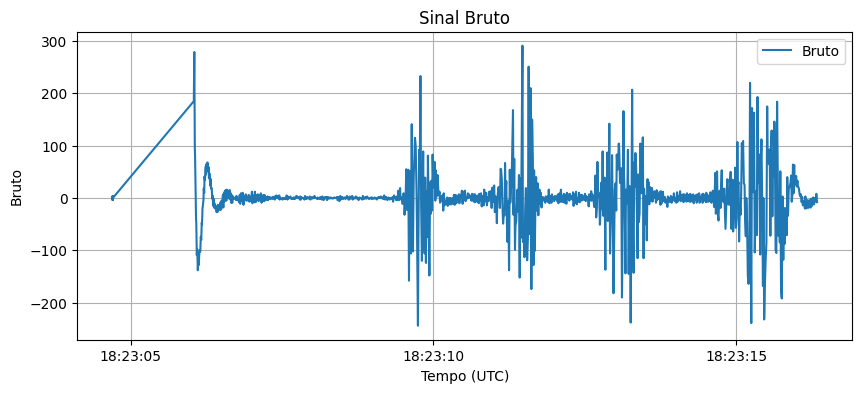

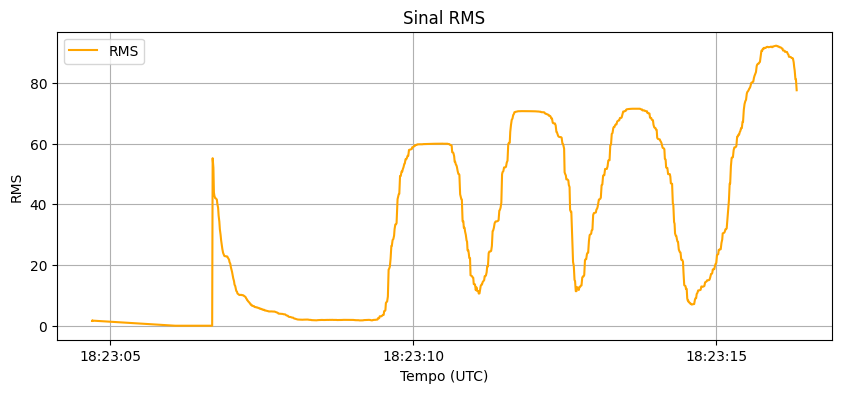

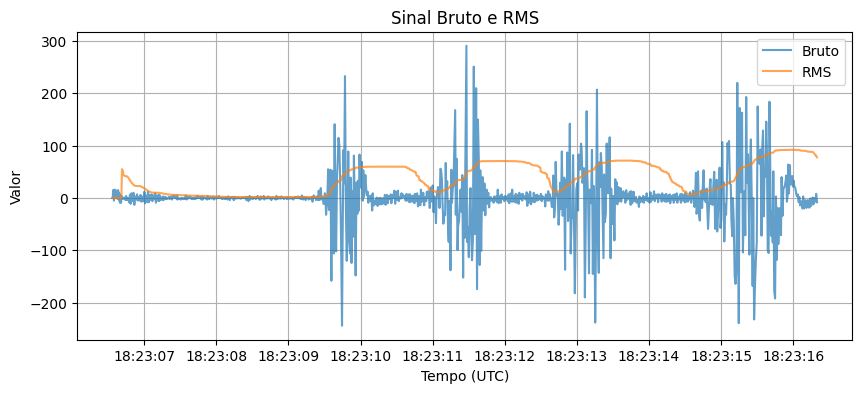

: 

In [ ]:
df = load_serial_csv()
plot_bruto(df)
plot_rms(df)
plot_both(df)